# CKME136 - Capstone Project - Toronto Real Estate Listings
## Step 2: Feature Engineering - with Pandas

### 2A. Imports for feature engineering

In [152]:
import csv
import datetime
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 10000)

### 2B. Read in listing other features

In [131]:
# read in individual_listing_other_Features
df_other_features = pd.read_csv('individual_listing_other_features_v3.csv')
# argument to convert string to list on read
# converters={"listing_features": literal_eval})

# read in individual_listing_rooms
df_rooms = pd.read_csv('individual_listing_rooms.csv')

### 2C. Use Pandas to transform listing other features data for predictions

In [132]:
#filter 1 - parking spots and other
filter_building_types = ['Parking', 'Other']
df_other_features['building_type_filter'] = df_other_features['dwelling_type'].str.split(',', expand = True)[0]
df_other_features = df_other_features[~df_other_features['building_type_filter'].str.contains('|'.join(filter_building_types))]
df_other_features.drop(['building_type_filter'], axis=1, inplace = True)

# extract mls id
df_other_features['listing_id'] = df_other_features['listing_url'].str.extract(r'[A-Z](\d{7})', expand=True)

# convert dollars to int
def convert_dollar_string_to_int(column):
    df_other_features[column+'_int'] = df_other_features[column].replace('[\$,]', '', regex=True).astype(int)

convert_dollar_string_to_int('listing_price')
convert_dollar_string_to_int('comparable_sold_price_1')
# convert_dollar_string_to_int('comparable_list_price_1')
convert_dollar_string_to_int('comparable_sold_price_2')
# convert_dollar_string_to_int('comparable_list_price_2')
convert_dollar_string_to_int('comparable_sold_price_3')
# convert_dollar_string_to_int('comparable_list_price_3')
convert_dollar_string_to_int('comparable_sold_price_4')
# convert_dollar_string_to_int('comparable_list_price_4')
convert_dollar_string_to_int('comparable_sold_price_5')
# convert_dollar_string_to_int('comparable_list_price_5')

#filter 2 - filter out listing price beyond max comparable sold price
df_other_features = df_other_features.where(df_other_features['listing_price_int'] <= df_other_features['comparable_sold_price_1_int'].max()) 


# extract postal code via one-hot encoding
# df_other_features['postal_code'] = df_other_features['address'].str.split(',', expand = True)[2].str.split(expand = True)[1]
# df_other_features['postal_code_fsa'] = df_other_features['address'].str.split(',', expand = True)[2].str.split(expand = True)[1].astype(str).str[:3]
# df_other_features['postal_code_ldu'] = df_other_features['address'].str.split(',', expand = True)[2].str.split(expand = True)[1].astype(str).str[3:]
df_series_fsa = df_other_features['address'].str.split(',', expand = True)[2].str.split(expand = True)[1].astype(str).str[:3]
df_postal_code_fsa = pd.get_dummies(df_series_fsa)
pca = PCA(n_components=1)
postal_code_fsa_pca = pca.fit_transform(df_postal_code_fsa)
df_postal_code_fsa_pca = pd.DataFrame(data = postal_code_fsa_pca, columns = ['postal_code_principal_component'])

# extract community via one-hot encoding
# df_other_features['community'] = df_other_features['address'].str.split(',', expand = True)[1]
df_series_community = df_other_features['address'].str.split(',', expand = True)[1]
df_community = pd.get_dummies(df_series_community)
community_pca = pca.fit_transform(df_community)
df_community_pca = pd.DataFrame(data = community_pca, columns = ['community_principal_component'])

# building type via one-hot encoding
# df_other_features['building_type'] = df_other_features['dwelling_type'].str.split(',', expand = True)[0]
df_series_building_type = df_other_features['dwelling_type'].str.split(',', expand = True)[0]
df_building_type = pd.get_dummies(df_series_building_type)

# number of room features
df_other_features['main_rooms'] = df_other_features['dwelling_type'].str.split(',', expand = True)[1].str.split(pat = '(\d+)', expand = True)[1]
df_other_features['additional_rooms'] = df_other_features['dwelling_type'].str.split(',', expand = True)[1].str.split(pat = '(\d+)', expand = True)[3]

# change to numbers and fill
df_other_features['main_rooms'] = pd.to_numeric(df_other_features.main_rooms).fillna(0).astype(int)
df_other_features['additional_rooms'] = pd.to_numeric(df_other_features.additional_rooms).fillna(0).astype(int)

# generate total rooms
df_other_features['total_rooms'] = df_other_features['main_rooms'] + df_other_features['additional_rooms']

# of parking spaces
df_other_features['parking_spaces'] = df_other_features['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[1]
# this coerce may lose us some data as listings with parking space 's1' will be converted to 0
df_other_features['parking_spaces'] = pd.to_numeric(df_other_features.parking_spaces, errors='coerce').fillna(0).astype(int)

# of kitchens
df_other_features['main_kitchen'] = df_other_features['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[0].str.split(pat = '+', expand = True)[0]
df_other_features['additional_kitchen'] = df_other_features['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[0].str.split(pat = '+', expand = True)[1]

df_other_features['main_kitchen'] = pd.to_numeric(df_other_features.main_kitchen).fillna(0).astype(int)
df_other_features['additional_kitchen'] = pd.to_numeric(df_other_features.additional_kitchen).fillna(0).astype(int)
df_other_features['total_kitchens'] = df_other_features['main_kitchen'] + df_other_features['additional_kitchen']

# convert string dates to datetime
def convert_string_to_date(column):
#     df_other_features[column+'_datetime'] = pd.to_datetime(df_other_features[column])
    a = pd.to_datetime(df_other_features[column], errors = 'coerce')
    df_other_features[column+'_datetime'] = a.apply(lambda x: datetime.datetime.now() - x).astype(int)
    
# convert_string_to_date('comparable_sold_date_1')
# convert_string_to_date('comparable_sold_date_2')
# convert_string_to_date('comparable_sold_date_3')
# convert_string_to_date('comparable_sold_date_4')
# convert_string_to_date('comparable_sold_date_5')

# extras
df_other_features['extras_fridge'] = df_other_features['listing_extras'].str.lower().str.contains('fridge').fillna(0).astype(int)
df_other_features['extras_stove'] = df_other_features['listing_extras'].str.lower().str.contains('stove').fillna(0).astype(int)
df_other_features['extras_stainless_steel'] = df_other_features['listing_extras'].str.lower().str.contains('stainless steel').fillna(0).astype(int)
df_other_features['extras_pool'] = df_other_features['listing_extras'].str.lower().str.contains('pool').fillna(0).astype(int)
df_other_features['extras_gym'] = df_other_features['listing_extras'].str.lower().str.contains('gym').fillna(0).astype(int)
df_other_features['extras_storage'] = df_other_features['listing_extras'].str.lower().str.contains('storage').fillna(0).astype(int)
df_other_features['extras_locker'] = df_other_features['listing_extras'].str.lower().str.contains('locker').fillna(0).astype(int)
df_other_features['extras_gas'] = df_other_features['listing_extras'].str.lower().str.contains('gas').fillna(0).astype(int)
df_other_features['extras_dishwasher'] = df_other_features['listing_extras'].str.lower().str.contains('dishwasher').fillna(0).astype(int)

# features
df_other_features['features_view'] = df_other_features['listing_features'].str.lower().str.contains('view').fillna(0).astype(int)
df_other_features['features_park'] = df_other_features['listing_features'].str.lower().str.contains('park').fillna(0).astype(int)
df_other_features['features_public_transit'] = df_other_features['listing_features'].str.lower().str.contains('public transit').fillna(0).astype(int)
df_other_features['features_basementbrick'] = df_other_features['listing_features'].str.lower().str.contains('basementbrick').fillna(0).astype(int)
df_other_features['features_concrete_exterior'] = df_other_features['listing_features'].str.lower().str.contains('concrete exterior').fillna(0).astype(int)
df_other_features['features_hospital'] = df_other_features['listing_features'].str.lower().str.contains('hospital').fillna(0).astype(int)
df_other_features['features_library'] = df_other_features['listing_features'].str.lower().str.contains('library').fillna(0).astype(int)

# description length
df_other_features['listing_description_length'] = df_other_features['listing_description'].str.len().fillna(0).astype(int)

#filter 1 - remove nan
df_other_features.dropna(inplace = True)

In [134]:
# create clean dataset for other features
df_other_features_listing_url = df_other_features.iloc[:,0:1]
df_other_features_dataset = df_other_features.iloc[:,23:]
df_other_features_frames = [df_other_features_listing_url, df_other_features_dataset, df_postal_code_fsa_pca, df_community_pca, df_building_type]
df_other_features_dataset = pd.concat(df_other_features_frames, axis=1)
# remove nulls
df_other_features_dataset.dropna(inplace = True)

### 2D. Use Pandas to transform rooms features data for predictions

In [135]:
df_rooms.head()

,listing_url,OFFICE,FAMILY ROOM,DINING ROOM,DEN,REC,FOYER,2ND BEDROOM,BATHROOM,BATHROOMS,...,SUNROOM,GREAT ROOM,LAUNDRY,SITTING,SOLARIUM,LOCKER,BEDROOM,BREAKFAST,MEDIA/ENT,UTILITY
0,https://toronto.listing.ca/168-bonis-ave-1211.E4349723.htm#15-1dr,NaN,NaN,"Flat Level, 6.51m x 4.00mLaminate, W/O To Balcony, Open Concept","Flat Level, 3.90m x 3.40mLaminate, Overlook Golf Course, B/I Shelves",NaN,NaN,"Flat Level, 3.96m x 3.44mLaminate, W/W Closet, Window",NaN,6-piece on flat level3-piece on flat level,...,NaN,NaN,"Flat Level, 3.31m x 1.74mCeramic Floor, B/I Shelves, Separate Rm",NaN,NaN,"Bsmt Level, 5.00m x 2.93mVinyl Floor, Finished",NaN,"Flat Level, 2.64m x 2.43mCeramic Floor, W/O To Balcony, Overlook Golf Course",NaN,NaN
1,https://toronto.listing.ca/3300-don-mills-rd-310.C4359682.htm#15-oy,NaN,NaN,"Flat Level, 3.81m x 3.58m",NaN,NaN,NaN,"Flat Level, 3.65m x 3.00mB/I Desk, O/Looks Garden",NaN,NaN,...,NaN,NaN,"Flat Level, 2.60m x 1.20m",NaN,NaN,"Flat Level, 3.05m x 1.28m",NaN,NaN,NaN,NaN
2,https://toronto.listing.ca/65-east-liberty-st-627.C4353207.htm#15-16k,NaN,NaN,"Main Level, 4.52m x 2.50mLaminate, Combined W/Living, Open Concept",NaN,NaN,NaN,NaN,NaN,4-piece on main level,...,NaN,NaN,NaN,NaN,NaN,NaN,"Main Level, 2.52m x 3.20mLaminate, Closet",NaN,NaN,NaN
3,https://toronto.listing.ca/45-skylark-rd.W4341830.htm#15-1r3,NaN,NaN,"Main Level, 5.79m x 2.74mCombined W/Living, Hardwood Floor",NaN,"Bsmt Level, 4.57m x 4.57mHardwood Floor",NaN,"2nd Level, 3.17m x 2.77mHardwood Floor, Large Closet, O/Looks Backyard",NaN,4-piece on 2nd level2-piece on bsmt level,...,"Main Level, 3.35m x 2.74mO/Looks Garden",NaN,"Bsmt Level, 2.13m x 1.52m2 Pc Bath",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://toronto.listing.ca/88-north-bonnington-ave.E4252454.htm#15-2n1,NaN,NaN,NaN,NaN,NaN,NaN,"Flat Level, 2.43m x 2.13mHardwood Floor, Window, Closet",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df_rooms.drop('LEGAL DESCRIPTION', axis = 1, inplace = True)

In [137]:
# list of rooms for Booleans
room_list_bools = df_rooms.dtypes.index.tolist()
room_list_bools.remove('listing_url')
# list of rooms for Sizes
room_list_sizes = df_rooms.dtypes.index.tolist()
room_list_sizes.remove('listing_url')
room_list_sizes.remove('BATHROOM')
room_list_sizes.remove('BATHROOMS')

In [138]:
# listing url
df_rooms_listing_url = df_rooms.iloc[:,0:1]

In [139]:
# boolean_rooms
df_rooms_bool = df_rooms[room_list_bools].notna()
# df_rooms_bool['total_room_count'] = df_rooms_bool.sum(axis=1)

In [140]:
def room_sqft(df_rooms, room_name):
    df = df_rooms[['listing_url', room_name]]
    df['length'] = df[room_name].str.extract('(\d+\.\d{2})', expand = True).fillna(0).astype(float)
    df['width'] = df[room_name].str.extract('((?<= x).\d+\.\d{2})', expand = True).fillna(0).astype(float)
    df[room_name+' sqft'] = df.length*df.width
    df.drop(['length', 'width', room_name], axis = 1, inplace = True)
    return df

In [141]:
# loop through rooms to calculate sqft
df_rooms_sqft = df_rooms.iloc[:,0:1]
for i in room_list_sizes:
    df_sqft = room_sqft(df_rooms, i)
    df_rooms_sqft = df_sqft.merge(df_rooms_sqft, on = 'listing_url')

# drop listing_url
df_rooms_sqft.drop('listing_url', axis = 1, inplace = True)

# total room square feet calculation
df_rooms_sqft['total_room_sqft'] = df_rooms_sqft.sum(axis=1)

/artifacts/virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/artifacts/virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/artifacts/virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [142]:
#join dataframes
frames = [df_rooms_listing_url, df_rooms_bool, df_rooms_sqft]
df_rooms_dataset = pd.concat(frames, axis=1)
df_rooms_dataset.head()

,listing_url,OFFICE,FAMILY ROOM,DINING ROOM,DEN,REC,FOYER,2ND BEDROOM,BATHROOM,BATHROOMS,...,EXERCISE sqft,LIBRARY sqft,2ND BEDROOM sqft,FOYER sqft,REC sqft,DEN sqft,DINING ROOM sqft,FAMILY ROOM sqft,OFFICE sqft,total_room_sqft
0,https://toronto.listing.ca/168-bonis-ave-1211.E4349723.htm#15-1dr,False,False,True,True,False,False,True,False,True,...,0.0,0.0,13.6224,0.0,0.0000,13.26,26.0400,0.0,0.0,122.7564
1,https://toronto.listing.ca/3300-don-mills-rd-310.C4359682.htm#15-oy,False,False,True,False,False,False,True,False,False,...,0.0,0.0,10.9500,0.0,0.0000,0.00,13.6398,0.0,0.0,84.6665
2,https://toronto.listing.ca/65-east-liberty-st-627.C4353207.htm#15-16k,False,False,True,False,False,False,False,False,True,...,0.0,0.0,0.0000,0.0,0.0000,0.00,11.3000,0.0,0.0,30.6640
3,https://toronto.listing.ca/45-skylark-rd.W4341830.htm#15-1r3,False,False,True,False,True,False,True,False,True,...,0.0,0.0,8.7809,0.0,20.8849,0.00,15.8646,0.0,0.0,99.9440
4,https://toronto.listing.ca/88-north-bonnington-ave.E4252454.htm#15-2n1,False,False,False,False,False,False,True,False,False,...,0.0,0.0,5.1759,0.0,0.0000,0.00,0.0000,0.0,0.0,42.1515


### 2E. Join datasets together and write to CSV

In [143]:
# Join rooms and other features datasets together
df_all_features_dataset = df_other_features_dataset.merge(df_rooms_dataset, on = 'listing_url')

In [144]:
log_list = list(df_all_features_dataset)
log_list.remove('listing_url')
log_list.remove('listing_id')
log_list.remove('extras_fridge')
log_list.remove('extras_stove')
log_list.remove('extras_stainless_steel')
log_list.remove('extras_pool')
log_list.remove('extras_gym')
log_list.remove('extras_storage')
log_list.remove('extras_locker')
log_list.remove('extras_gas')
log_list.remove('extras_dishwasher')
log_list.remove('features_view')
log_list.remove('features_park')
log_list.remove('features_public_transit')
log_list.remove('features_basementbrick')
log_list.remove('features_concrete_exterior')
log_list.remove('features_hospital')
log_list.remove('features_library')
log_list.remove('postal_code_principal_component')
log_list.remove('community_principal_component')
log_list.remove('1 1/2 Storey')
log_list.remove('2 1/2 Storey')
log_list.remove('2-Storey')
log_list.remove('3-Storey')
log_list.remove('Apartment')
log_list.remove('Bachelor/Studio')
log_list.remove('Backsplit 3')
log_list.remove('Backsplit 4')
log_list.remove('Backsplit 5')
log_list.remove('Bungaloft')
log_list.remove('Bungalow')
log_list.remove('Bungalow-Raised')
log_list.remove('Loft')
log_list.remove('Multi-Level')
log_list.remove('Sidesplit 3')
log_list.remove('Sidesplit 4')
log_list.remove('Sidesplit 5')
log_list.remove('Stacked Townhse')
log_list.remove('OFFICE')
log_list.remove('FAMILY ROOM')
log_list.remove('DINING ROOM')
log_list.remove('DEN')
log_list.remove('REC')
log_list.remove('FOYER')
log_list.remove('2ND BEDROOM')
log_list.remove('BATHROOM')
log_list.remove('BATHROOMS')
log_list.remove('LIBRARY')
log_list.remove('EXERCISE')
log_list.remove('KITCHEN')
log_list.remove('LIVING ROOM')
log_list.remove('MASTER BEDROOM')
log_list.remove('STUDY')
log_list.remove('4TH BEDROOM')
log_list.remove('3RD BEDROOM')
log_list.remove('OTHER')
log_list.remove('5TH BEDROOM')
log_list.remove('SUNROOM')
log_list.remove('GREAT ROOM')
log_list.remove('LAUNDRY')
log_list.remove('SITTING')
log_list.remove('SOLARIUM')
log_list.remove('LOCKER')
log_list.remove('BEDROOM')
log_list.remove('BREAKFAST')
log_list.remove('MEDIA/ENT')
log_list.remove('UTILITY')

In [146]:
def log_drop_attribute(column_name):
    df_all_features_dataset[column_name+'_log'] = np.log(df_all_features_dataset[column_name] + 1)
    df_all_features_dataset.drop(column_name, inplace = True, axis = 1)

In [147]:
for i in log_list:
    log_drop_attribute(i)

In [148]:
df_all_features_dataset['listing_price_int_log'].head()

0    13.710040
1    12.959847
2    13.081335
3    13.763165
4    13.429850
Name: listing_price_int_log, dtype: float64

In [149]:
# Check data types of all features
df_all_features_dataset.dtypes

listing_url                         object
listing_id                          object
extras_fridge                      float64
extras_stove                       float64
extras_stainless_steel             float64
extras_pool                        float64
extras_gym                         float64
extras_storage                     float64
extras_locker                      float64
extras_gas                         float64
extras_dishwasher                  float64
features_view                      float64
features_park                      float64
features_public_transit            float64
features_basementbrick             float64
features_concrete_exterior         float64
features_hospital                  float64
features_library                   float64
postal_code_principal_component    float64
community_principal_component      float64
1 1/2 Storey                       float64
2 1/2 Storey                       float64
2-Storey                           float64
3-Storey   

In [150]:
# count of dataset
df_all_features_dataset.count()

listing_url                        3290
listing_id                         3290
extras_fridge                      3290
extras_stove                       3290
extras_stainless_steel             3290
extras_pool                        3290
extras_gym                         3290
extras_storage                     3290
extras_locker                      3290
extras_gas                         3290
extras_dishwasher                  3290
features_view                      3290
features_park                      3290
features_public_transit            3290
features_basementbrick             3290
features_concrete_exterior         3290
features_hospital                  3290
features_library                   3290
postal_code_principal_component    3290
community_principal_component      3290
1 1/2 Storey                       3290
2 1/2 Storey                       3290
2-Storey                           3290
3-Storey                           3290
Apartment                          3290


In [125]:
# Write to CSV
df_all_features_dataset.to_csv('cleaned_combined_listing_features_v8.csv')

In [151]:
df_all_features_dataset.head()

,listing_url,listing_id,extras_fridge,extras_stove,extras_stainless_steel,extras_pool,extras_gym,extras_storage,extras_locker,extras_gas,...,EXERCISE sqft_log,LIBRARY sqft_log,2ND BEDROOM sqft_log,FOYER sqft_log,REC sqft_log,DEN sqft_log,DINING ROOM sqft_log,FAMILY ROOM sqft_log,OFFICE sqft_log,total_room_sqft_log
0,https://toronto.listing.ca/168-bonis-ave-1211.E4349723.htm#15-1dr,4349723,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.682555,0.0,0.000000,2.657458,3.297317,0.0,0.0,4.818315
1,https://toronto.listing.ca/3300-don-mills-rd-310.C4359682.htm#15-oy,4359682,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.480731,0.0,0.000000,0.000000,2.683744,0.0,0.0,4.450462
2,https://toronto.listing.ca/65-east-liberty-st-627.C4353207.htm#15-16k,4353207,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.509599,0.0,0.0,3.455180
3,https://toronto.listing.ca/45-skylark-rd.W4341830.htm#15-1r3,4341830,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.280432,0.0,3.085797,0.000000,2.825217,0.0,0.0,4.614566
4,https://toronto.listing.ca/88-north-bonnington-ave.E4252454.htm#15-2n1,4252454,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.820655,0.0,0.000000,0.000000,0.000000,0.0,0.0,3.764717


### 2F. Heat map to find correlated events

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

heatmap_df = df_all_features_dataset.iloc[:,2:]
heatmap_corr = heatmap_df.astype(float).corr()

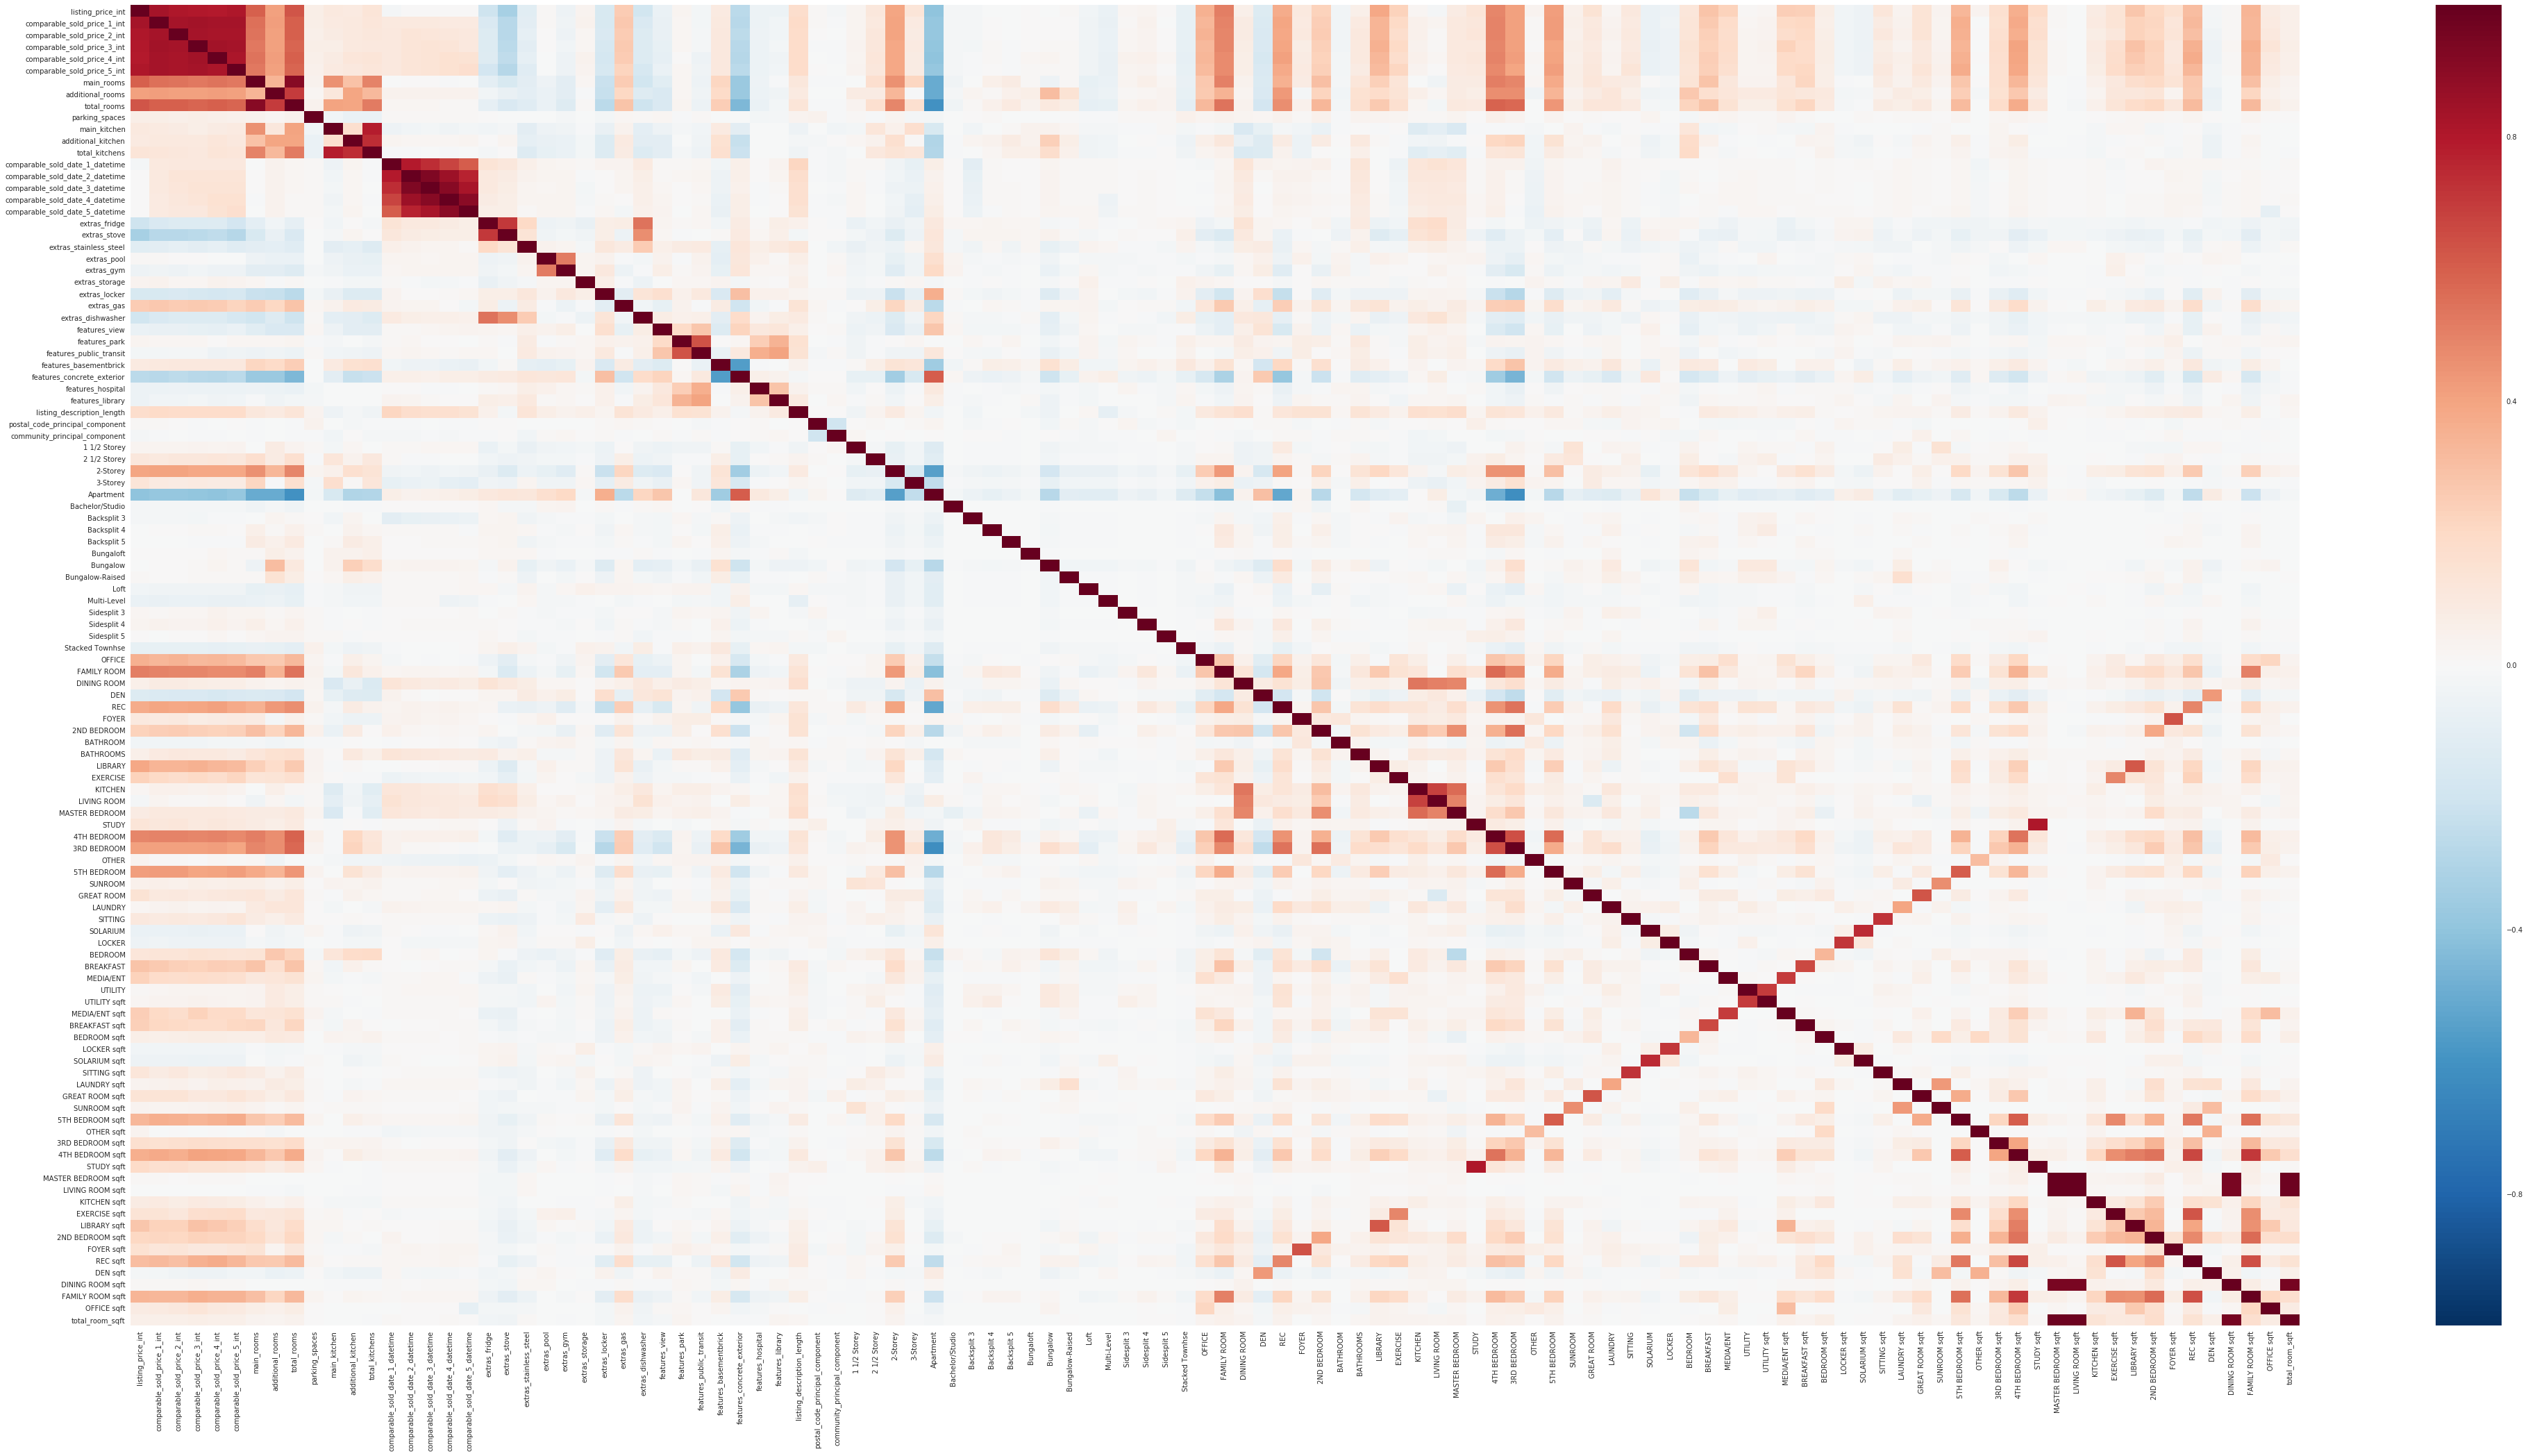

In [48]:
plt.figure(figsize=(70,35))
sns.heatmap(heatmap_corr)

In [49]:
heatmap_corr

,listing_price_int,comparable_sold_price_1_int,comparable_sold_price_2_int,comparable_sold_price_3_int,comparable_sold_price_4_int,comparable_sold_price_5_int,main_rooms,additional_rooms,total_rooms,parking_spaces,...,EXERCISE sqft,LIBRARY sqft,2ND BEDROOM sqft,FOYER sqft,REC sqft,DEN sqft,DINING ROOM sqft,FAMILY ROOM sqft,OFFICE sqft,total_room_sqft
listing_price_int,1.000000,0.830581,0.808293,0.797825,0.790780,0.805184,0.593889,0.410892,0.632367,0.066313,...,0.135580,0.278476,0.207807,0.155548,0.307855,-0.020225,0.013874,0.338119,0.085462,0.058175
comparable_sold_price_1_int,0.830581,1.000000,0.830180,0.842633,0.834086,0.835678,0.550044,0.416620,0.601546,0.063313,...,0.137117,0.233453,0.211093,0.124941,0.322461,-0.027592,0.014109,0.335582,0.086878,0.058753
comparable_sold_price_2_int,0.808293,0.830180,1.000000,0.833629,0.823622,0.825677,0.543474,0.411967,0.594503,0.059780,...,0.117152,0.230852,0.208573,0.125302,0.299037,-0.043237,0.014268,0.329416,0.102210,0.055211
comparable_sold_price_3_int,0.797825,0.842633,0.833629,1.000000,0.838720,0.828905,0.525887,0.408236,0.579488,0.064425,...,0.168179,0.292200,0.231194,0.103465,0.352572,-0.047257,0.018868,0.362086,0.125859,0.066702
comparable_sold_price_4_int,0.790780,0.834086,0.823622,0.838720,1.000000,0.817466,0.542263,0.415285,0.595042,0.061250,...,0.175437,0.271002,0.221539,0.105699,0.374761,-0.048781,0.013734,0.350052,0.095622,0.062264
comparable_sold_price_5_int,0.805184,0.835678,0.825677,0.828905,0.817466,1.000000,0.530570,0.411450,0.584463,0.054450,...,0.183892,0.234786,0.224361,0.119134,0.335277,-0.035553,0.010316,0.347727,0.092356,0.058486
main_rooms,0.593889,0.550044,0.543474,0.525887,0.542263,0.530570,1.000000,0.341119,0.910486,0.039603,...,0.106581,0.173324,0.200390,0.135640,0.265753,-0.038253,-0.003594,0.298175,0.067395,0.037617
additional_rooms,0.410892,0.416620,0.411967,0.408236,0.415285,0.411450,0.341119,1.000000,0.699319,0.021349,...,0.109799,0.114139,0.129870,0.025740,0.264369,-0.064572,-0.002385,0.213866,0.054165,0.030005
total_rooms,0.632367,0.601546,0.594503,0.579488,0.595042,0.584463,0.910486,0.699319,1.000000,0.039507,...,0.129349,0.182012,0.209514,0.114467,0.318387,-0.057495,-0.003782,0.320823,0.075077,0.041804
parking_spaces,0.066313,0.063313,0.059780,0.064425,0.061250,0.054450,0.039603,0.021349,0.039507,1.000000,...,0.011069,0.019098,0.019556,0.013675,0.031126,0.002481,-0.000678,0.025462,0.005260,0.001928


### 2G. Create descriptive analytics dataset

In [6]:
# read in individual_listing_other_Features
df_other_features_desc = pd.read_csv('individual_listing_other_features_v3.csv')
# read in individual_listing_rooms
df_rooms_desc = pd.read_csv('individual_listing_rooms.csv')

In [7]:
# extract mls id
df_other_features_desc['listing_id'] = df_other_features_desc['listing_url'].str.extract(r'[A-Z](\d{7})', expand=True)

# convert dollars to int
def convert_dollar_string_to_int(column):
    df_other_features_desc[column+'_int'] = df_other_features_desc[column].replace('[\$,]', '', regex=True).astype(int)

convert_dollar_string_to_int('listing_price')
convert_dollar_string_to_int('comparable_sold_price_1')
convert_dollar_string_to_int('comparable_list_price_1')
convert_dollar_string_to_int('comparable_sold_price_2')
convert_dollar_string_to_int('comparable_list_price_2')
convert_dollar_string_to_int('comparable_sold_price_3')
convert_dollar_string_to_int('comparable_list_price_3')
convert_dollar_string_to_int('comparable_sold_price_4')
convert_dollar_string_to_int('comparable_list_price_4')
convert_dollar_string_to_int('comparable_sold_price_5')
convert_dollar_string_to_int('comparable_list_price_5')

# extract postal code
df_other_features_desc['postal_code'] = df_other_features_desc['address'].str.split(',', expand = True)[2].str.split(expand = True)[1]
df_other_features_desc['postal_code_fsa'] = df_other_features_desc['address'].str.split(',', expand = True)[2].str.split(expand = True)[1].astype(str).str[:3]
df_other_features_desc['postal_code_ldu'] = df_other_features_desc['address'].str.split(',', expand = True)[2].str.split(expand = True)[1].astype(str).str[3:]

# extract community
df_other_features_desc['community'] = df_other_features_desc['address'].str.split(',', expand = True)[1]

# building type
df_other_features_desc['building_type'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[0]

# number of room features
df_other_features_desc['main_rooms'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[1].str.split(pat = '(\d+)', expand = True)[1]
df_other_features_desc['additional_rooms'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[1].str.split(pat = '(\d+)', expand = True)[3]

# change to numbers and fill
df_other_features_desc['main_rooms'] = pd.to_numeric(df_other_features_desc.main_rooms).fillna(0).astype(int)
df_other_features_desc['additional_rooms'] = pd.to_numeric(df_other_features_desc.additional_rooms).fillna(0).astype(int)

# generate total rooms
df_other_features_desc['total_rooms'] = df_other_features_desc['main_rooms'] + df_other_features_desc['additional_rooms']

# of parking spaces
df_other_features_desc['parking_spaces'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[1]
# this coerce may lose us some data as listings with parking space 's1' will be converted to 0
df_other_features_desc['parking_spaces'] = pd.to_numeric(df_other_features_desc.parking_spaces, errors='coerce').fillna(0).astype(int)

# of kitchens
df_other_features_desc['main_kitchen'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[0].str.split(pat = '+', expand = True)[0]
df_other_features_desc['additional_kitchen'] = df_other_features_desc['dwelling_type'].str.split(',', expand = True)[2].str.split(pat = 'Parking', expand = True)[0].str.split(pat = 'Kitchen|Kitchens', expand = True)[0].str.split(pat = '+', expand = True)[1]

df_other_features_desc['main_kitchen'] = pd.to_numeric(df_other_features_desc.main_kitchen).fillna(0).astype(int)
df_other_features_desc['additional_kitchen'] = pd.to_numeric(df_other_features_desc.additional_kitchen).fillna(0).astype(int)
df_other_features_desc['total_kitchens'] = df_other_features_desc['main_kitchen'] + df_other_features_desc['additional_kitchen']

# convert string dates to datetime
def convert_string_to_date(column):
#     df_other_features[column+'_datetime'] = pd.to_datetime(df_other_features[column])
    a = pd.to_datetime(df_other_features_desc[column], errors = 'coerce')
    df_other_features_desc[column+'_datetime'] = a.apply(lambda x: datetime.datetime.now() - x).astype(int)
    
convert_string_to_date('comparable_sold_date_1')
convert_string_to_date('comparable_sold_date_2')
convert_string_to_date('comparable_sold_date_3')
convert_string_to_date('comparable_sold_date_4')
convert_string_to_date('comparable_sold_date_5')

# extras
df_other_features_desc['extras_fridge'] = df_other_features_desc['listing_extras'].str.lower().str.contains('fridge').fillna(0).astype(int)
df_other_features_desc['extras_stove'] = df_other_features_desc['listing_extras'].str.lower().str.contains('stove').fillna(0).astype(int)
df_other_features_desc['extras_stainless_steel'] = df_other_features_desc['listing_extras'].str.lower().str.contains('stainless steel').fillna(0).astype(int)
df_other_features_desc['extras_pool'] = df_other_features_desc['listing_extras'].str.lower().str.contains('pool').fillna(0).astype(int)
df_other_features_desc['extras_gym'] = df_other_features_desc['listing_extras'].str.lower().str.contains('gym').fillna(0).astype(int)
df_other_features_desc['extras_storage'] = df_other_features_desc['listing_extras'].str.lower().str.contains('storage').fillna(0).astype(int)
df_other_features_desc['extras_locker'] = df_other_features_desc['listing_extras'].str.lower().str.contains('locker').fillna(0).astype(int)
df_other_features_desc['extras_gas'] = df_other_features_desc['listing_extras'].str.lower().str.contains('gas').fillna(0).astype(int)
df_other_features_desc['extras_dishwasher'] = df_other_features_desc['listing_extras'].str.lower().str.contains('dishwasher').fillna(0).astype(int)

# features
df_other_features_desc['features_view'] = df_other_features_desc['listing_features'].str.lower().str.contains('view').fillna(0).astype(int)
df_other_features_desc['features_park'] = df_other_features_desc['listing_features'].str.lower().str.contains('park').fillna(0).astype(int)
df_other_features_desc['features_public_transit'] = df_other_features_desc['listing_features'].str.lower().str.contains('public transit').fillna(0).astype(int)
df_other_features_desc['features_basementbrick'] = df_other_features_desc['listing_features'].str.lower().str.contains('basementbrick').fillna(0).astype(int)
df_other_features_desc['features_concrete_exterior'] = df_other_features_desc['listing_features'].str.lower().str.contains('concrete exterior').fillna(0).astype(int)
df_other_features_desc['features_hospital'] = df_other_features_desc['listing_features'].str.lower().str.contains('hospital').fillna(0).astype(int)
df_other_features_desc['features_library'] = df_other_features_desc['listing_features'].str.lower().str.contains('library').fillna(0).astype(int)

# description length
df_other_features_desc['listing_description_length'] = df_other_features_desc['listing_description'].str.len().fillna(0).astype(int)



In [27]:
# create clean dataset for other features
df_other_features_desc_dataset = df_other_features_desc.drop(df_other_features_desc.columns[1:24], axis=1)

In [28]:
# boolean_rooms
df_rooms_desc_bool = df_rooms_desc.notna()
#select specific rows
df_rooms_desc_bool = df_rooms_desc_bool.iloc[:,1:]
df_rooms_desc_listing_url = df_rooms_desc.iloc[:,0:1]
#join dataframes
frames = [df_rooms_desc_listing_url, df_rooms_desc_bool]
df_rooms_desc_dataset = pd.concat(frames, axis=1)

In [30]:
# Join rooms and other features datasets together
df_all_features_desc_dataset = df_other_features_desc_dataset.merge(df_rooms_desc_dataset, on = 'listing_url')

In [31]:
# Write to CSV
df_all_features_desc_dataset.to_csv('cleaned_combined_listing_descriptive_analytics_v1.csv')

In [303]:
# find the term Lot Size
# soup.find("div", {"class": "lpc15"}).findNext("div", {"class": "lpc15"}).findNext("div", {"class": "lpc15"}).find_previous_sibling()
# soup.find('div', attrs={'style': 'color: #3a5fac; padding-top: 5px; font-size: 18px; '})